In [296]:
import sys
sys.path.append("../")
from tfMFs.tfCMF import tfCMF
# from dataset import create_synthetic_data
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [297]:
from scipy import stats

# 文長の生成

### Toxic Comment

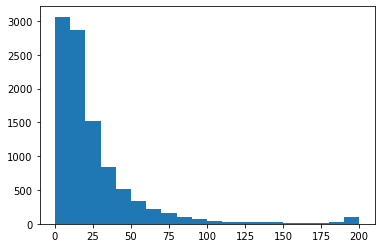

In [315]:
df = pd.read_csv("/home/ryo_matsui/notebook/mydata/ToxicComment/jigsaw-toxic-comment-train.csv")
vectorizer = CountVectorizer(min_df=0, max_df=np.inf, stop_words="english", binary=True)
X_toxic = vectorizer.fit_transform(df.head(10000).comment_text)
y_toxic = df.head(10000).toxic.values
plt.hist(np.clip(X_toxic.sum(axis=1).A.ravel(), 0,200),bins=20)
plt.show()

In [300]:
X.shape

(10000, 36074)

### 人工

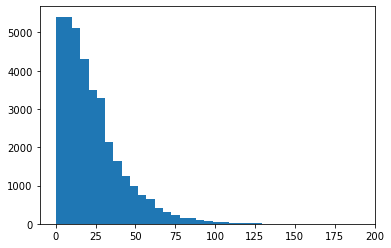

In [292]:
lam = stats.gamma.rvs(1.5,scale=15, size=36000)
length = stats.poisson.rvs(lam)
plt.hist(length,bins=50)
plt.xlim(-10,200)
plt.show()

# 単語 / トピックの生成

In [311]:
n_docs_pos = 1000
n_docs_neg = 9000
n_words = 36000
K = 10
lam = 10
r = 3

alpha_pos = np.random.rand(K)
alpha_neg = np.random.rand(K)
beta = np.random.rand(n_words)

theta_pos = stats.dirichlet.rvs(alpha_pos, size=n_docs_pos) # n_docs_pos × K
theta_neg = stats.dirichlet.rvs(alpha_neg, size=n_docs_neg) # n_docs_neg × K

lam_pos = stats.gamma.rvs(1.5,scale=15, size=n_docs_pos)
lam_neg = stats.gamma.rvs(1.5,scale=15, size=n_docs_neg)

length_pos = stats.poisson.rvs(lam_pos) # n_docs_pos
length_pos = stats.poisson.rvs(lam_neg) # n_docs_neg

z_pos = np.array([stats.multinomial.rvs(n=length_pos[i],p=theta_pos[i]) for i in range(n_docs_pos)]) # n_docs_pos × K
z_neg = np.array([stats.multinomial.rvs(n=length_neg[i],p=theta_neg[i]) for i in range(n_docs_neg)]) # n_docs_pos × K
z = np.r_[z_pos, z_neg]

phi = stats.dirichlet.rvs(beta, size=K) # K × n_words
X = np.array([
    np.array([stats.multinomial.rvs(n=z[i,k], p=phi[k]).tolist() for k in range(K)]).sum(axis=0)
    for i in range(n_docs_pos + n_docs_neg)
])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [351]:
def calc_sparsity(X):
    if X.__class__ == np.ndarray:
        sparsity = csr_matrix(X).nnz / X.shape[0] / X.shape[1]
    else:
        sparsity = X.nnz / X.shape[0] / X.shape[1]
    return sparsity

In [327]:
def clip_by_document_frequency(X, min_df, max_df):
    
    if X.__class__ == np.ndarray:
        df = X.sum(axis=0)
    else:
        df = X.sum(axis=0).A[0]
        
    lower_bound = df >= min_df
    upper_bound = df <= max_df
    
    X_cliped = X[:, lower_bound & upper_bound]
    return X_cliped

### clip 前のスパース性 / 頻度分布

#### - toxic

In [353]:
calc_sparsity(X_toxic)

0.0007108416033708489

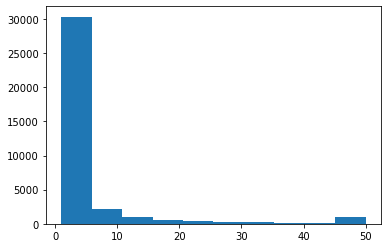

In [350]:
plt.hist(np.clip(X_toxic.sum(axis=0).A[0], 0,50),bins=10)
plt.show()

#### - synthetic

In [352]:
calc_sparsity(X)

0.0005415638888888889

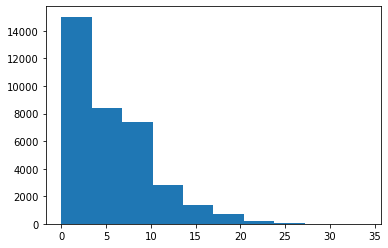

In [346]:
plt.hist(X.sum(axis=0),bins=10)
plt.show()

### clip後のスパース性 / 頻度分布

#### - toxic

In [338]:
X_toxic_clip = clip_by_document_frequency(X_toxic, 3, 10000)

In [354]:
X_toxic_clip.shape

(10000, 9927)

In [355]:
calc_sparsity(X_toxic_clip)

0.0022754104966253652

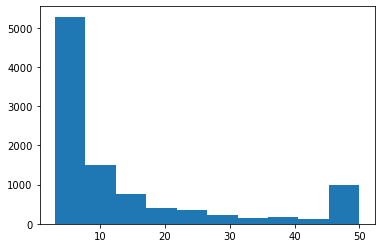

In [357]:
plt.hist(np.clip(X_toxic_clip.sum(axis=0).A[0], 0,50),bins=10)
plt.show()

#### - synthetic

In [337]:
X_clip = clip_by_document_frequency(X, 8, 10000)

In [358]:
X_clip.shape

(10000, 10242)